## Dependencies

In [1]:
import warnings
from tensorflow_hub import KerasLayer
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D
from googleqa_utilityscript import *
from googleqa_map_utilityscript import *
import bert_tokenization as tokenization
from script_lr_schedulers import RectifiedAdam


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [2]:
model_path = '/kaggle/working/model.h5'
BERT_PATH = '/kaggle/input/tf-hub-bert-base/bert_base_uncased'
TOKENIZER_PATH = BERT_PATH+'/assets/vocab.txt'

hold_out = pd.read_csv('/kaggle/input/googleqa-mldataset/hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']

print('Train samples: %s' % len(train))
print('Validation samples: %s' % len(validation))
display(train.head())

Train samples: 4863
Validation samples: 1216


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,set
0,3895,Magento (1.7) Bundled Product with FREE Produc...,I'm looking to create a bundle offer where cus...,Joe,https://magento.stackexchange.com/users/16572,"Since the third item is fixed, you can use sho...",Fabian Schmengler,https://magento.stackexchange.com/users/243,http://magento.stackexchange.com/questions/668...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,1.000000,0.000000,0.333333,0.888889,train
1,3131,Find router on network,I've just bought a Belkin N+ Wireless Router. ...,Guy,https://superuser.com/users/3248,You likely have the router plugged in to the m...,John T,https://superuser.com/users/1931,http://superuser.com/questions/87212,TECHNOLOGY,...,1.000000,0.666667,1.0,1.0,0.866667,0.666667,0.000000,1.000000,1.000000,train
2,1507,Negatively curved metrics minimizing the lengt...,Good afternoon everyone !\n\nI have the follow...,Selim G,https://mathoverflow.net/users/25511,A very partial answer: by the results of Richa...,Igor Rivin,https://mathoverflow.net/users/11142,http://mathoverflow.net/questions/203422,SCIENCE,...,0.888889,0.333333,1.0,1.0,0.700000,0.333333,0.333333,1.000000,0.888889,train
3,6784,Isn’t the FAQ label obsolete by now?,Don’t get me wrong in the beginning of reading...,Benny Skogberg,https://ux.stackexchange.com/users/4679,Isn’t the FAQ label obsolete by now? \n\nI'd s...,Solracnapod,https://ux.stackexchange.com/users/13153,http://ux.stackexchange.com/questions/18600/is...,TECHNOLOGY,...,0.888889,0.666667,1.0,1.0,0.933333,0.000000,0.000000,0.666667,1.000000,train
4,2135,Changing background image one time on responsi...,The code I'm using is this one \n\nbackground:...,user2141649,https://stackoverflow.com/users/2141649,&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&...,akkimads,https://stackoverflow.com/users/2375373,http://stackoverflow.com/questions/16359492/ch...,STACKOVERFLOW,...,0.888889,0.500000,1.0,1.0,0.800000,1.000000,0.000000,0.000000,0.777778,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

# Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']

for feature in text_features:
    # Lower
    train[feature] = train[feature].apply(lambda x: x.lower())
    validation[feature] = validation[feature].apply(lambda x: x.lower())
    # Map misspellings
    train[feature] = train[feature].apply(lambda x: map_misspellings(x))
    validation[feature] = validation[feature].apply(lambda x: map_misspellings(x))
    # Map contractions
    train[feature] = train[feature].apply(lambda x: map_contraction(x))
    validation[feature] = validation[feature].apply(lambda x: map_contraction(x))
    # Trim text
    train[feature] = train[feature].apply(lambda x: x.strip())
    validation[feature] = validation[feature].apply(lambda x: x.strip())

# Model parameters

In [5]:
EPOCHS = 12
BATCH_SIZE = 16
LEARNING_RATE = 3e-5
N_CLASS = len(target_cols)
ES_PATIENCE = 3
MAX_SEQUENCE_LENGTH = 512
TOTAL_STEPS = (len(train) // BATCH_SIZE) * EPOCHS

## Train/validation sets

In [6]:
tokenizer = tokenization.FullTokenizer(TOKENIZER_PATH, True)

# Train features
X_train = compute_input_arays(train, text_features, tokenizer, MAX_SEQUENCE_LENGTH)
Y_train = train[target_cols].values

# Validation features
X_valid = compute_input_arays(validation, text_features, tokenizer, MAX_SEQUENCE_LENGTH)
Y_valid = validation[target_cols].values


print('Train samples: %d' % len(Y_train))
print('Validation samples: %d' % len(Y_valid))

Train samples: 4863
Validation samples: 1216


# Model

In [7]:
input_word_ids = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids')
input_masks = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
segment_ids = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='segment_ids')

bert_layer = KerasLayer(BERT_PATH, trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_masks, segment_ids])

x = GlobalAveragePooling1D()(sequence_output)
x = Dropout(0.2)(x)
output = Dense(N_CLASS, kernel_initializer='glorot_uniform', activation="sigmoid", name="output")(x)

model = Model(inputs=[input_word_ids, input_masks, segment_ids], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_masks[0][0]            

# Train model

In [8]:
spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), 
                                       validation_data=(X_valid, Y_valid), 
                                       model_path=model_path, 
                                       monitor='val_loss', mode='min', 
                                       patience=ES_PATIENCE, checkpoint=True)

callback_list = [spearmanCallback]

optimizer = RectifiedAdam(lr=LEARNING_RATE,
                          total_steps=TOTAL_STEPS,
                          warmup_proportion=0.1,
                          min_lr=1e-7)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

history = model.fit(X_train, Y_train, 
                    validation_data=(X_valid, Y_valid), 
                    callbacks=callback_list, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2).history

Train on 4863 samples, validate on 1216 samples
Epoch 1/12
spearman-rho: 0.2513 val_spearman-rho: 0.2411
Saved model weights at "/kaggle/working/model.h5"
4863/4863 - 550s - loss: 0.5242 - val_loss: 0.4103
Epoch 2/12
spearman-rho: 0.3568 val_spearman-rho: 0.3303
Saved model weights at "/kaggle/working/model.h5"
4863/4863 - 469s - loss: 0.4003 - val_loss: 0.3874
Epoch 3/12
spearman-rho: 0.4215 val_spearman-rho: 0.3659
Saved model weights at "/kaggle/working/model.h5"
4863/4863 - 470s - loss: 0.3779 - val_loss: 0.3751
Epoch 4/12
spearman-rho: 0.4678 val_spearman-rho: 0.3765
Saved model weights at "/kaggle/working/model.h5"
4863/4863 - 470s - loss: 0.3643 - val_loss: 0.3726
Epoch 5/12
spearman-rho: 0.5144 val_spearman-rho: 0.3791
4863/4863 - 468s - loss: 0.3508 - val_loss: 0.3750
Epoch 6/12
spearman-rho: 0.5593 val_spearman-rho: 0.3764
4863/4863 - 468s - loss: 0.3368 - val_loss: 0.3796
Epoch 7/12
spearman-rho: 0.6013 val_spearman-rho: 0.3761
Epoch 00006: early stopping
4863/4863 - 468s - 

## Model loss graph

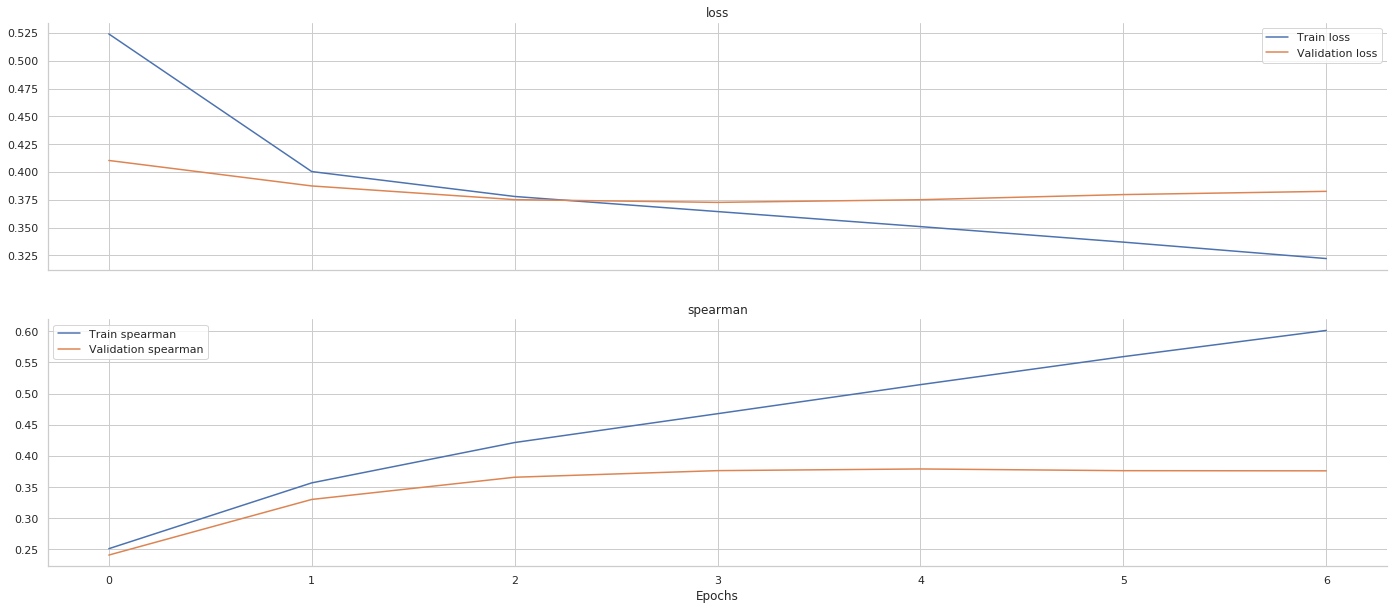

In [9]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'spearman'])

# Evaluation

In [10]:
model.load_weights(model_path)
preds_train = model.predict(X_train)
preds_val = model.predict(X_valid)

display(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols).style.applymap(color_map))

,Label,Train,Validation,Var
0,Averaged,0.468,0.376,0.092
1,Question averaged,0.492,0.406,0.086
2,Answer averaged,0.412,0.309,0.103
3,question_asker_intent_understanding,0.404,0.347,0.057
4,question_body_critical,0.664,0.569,0.095
5,question_conversational,0.457,0.417,0.04
6,question_expect_short_answer,0.469,0.294,0.175
7,question_fact_seeking,0.513,0.342,0.171
8,question_has_commonly_accepted_answer,0.556,0.45,0.106
9,question_interestingness_others,0.394,0.33,0.064


## By category

In [11]:
target_cols_preds = [col+'_pred' for col in target_cols]
for col in target_cols_preds:
    train[col] = 0
    validation[col] = 0
    
train[target_cols_preds] = preds_train
validation[target_cols_preds] = preds_val
    
display(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category').style.applymap(color_map))

,Label,Train,Validation,Var
0,TECHNOLOGY,0.432,0.332,0.1
1,SCIENCE,0.488,0.373,0.115
2,STACKOVERFLOW,0.352,0.235,0.117
3,LIFE_ARTS,0.498,0.415,0.083
4,CULTURE,0.496,0.383,0.113
